# **Importations** et chargement des données nettoyées

In [8]:
# Installation : pip install flake8 pycodestyle pycodestyle_magic
# Activate %%flake8 magic function
%load_ext pycodestyle_magic

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


In [9]:
# %%flake8  # checking PEP8 compliance

# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import functions.functions_p5 as functions_p5

In [10]:
# Reload importation of module
import importlib
importlib.reload(functions_p5);

In [11]:
# Load file with cleaned data
# X_std = pd.read_csv("data\p5_data_std.csv", index_col='Unnamed: 0')
X_std = pd.read_csv("data\p5_data_PCA.csv", index_col='Unnamed: 0')
#X_std = pd.read_csv("data\p5_data_RFM.csv", index_col='Unnamed: 0')

# X_std = pd.read_feather("data\p5_data_RFM.ft")


# Set maximum number of columns
pd.set_option("display.max_columns", 1000)
display(X_std.head(2))
X_std.shape

,PCA_F1,PCA_F2,PCA_F3,PCA_F4,PCA_F5,PCA_F6,PCA_F7,PCA_F8,PCA_F9,PCA_F10,PCA_F11,PCA_F12,PCA_F13,PCA_F14,PCA_F15,PCA_F16,PCA_F17,PCA_F18,PCA_F19,PCA_F20,PCA_F21,PCA_F22,PCA_F23
0,0.019404,2.224307,-1.131549,0.969006,-1.997360,2.469327,-0.428762,-1.019771,-0.499067,-0.009706,-0.087167,0.018542,-0.188092,0.022906,0.160512,0.628954,0.017722,0.125261,0.319583,-0.423667,-0.080351,-0.620725,-1.649709
1,0.575380,2.799850,-1.785003,0.429419,-0.723785,0.886443,-2.314225,-1.481173,1.660471,-0.147778,-0.089337,-0.598532,0.285437,-1.170239,-1.010104,-0.898702,-0.950753,1.790117,0.148628,0.136725,0.775437,-0.921361,0.523037


(99441, 23)

### **Échantillonage** aléatoire

In [12]:
import random
from random import randrange

# Set random integer (seed)
seed = random.randrange(1000)

# Initialize the seed of pseudo-random generator
random.seed(seed)
print("Seed value: ", seed)

Seed value:  492


In [13]:
# Sampling from X_std
X_std = X_std.sample(n=10000, random_state=seed)

# **Segmentations**

## **Modèle naïf :** bissection aléatoire
Dans ce modèle naïf, nous considérons une segmentation aléatoire en deux groupes. Cela nous donne un score de référence (*'baseline'*).

### Évaluations avec coefficient de silhouette *s*

Le coefficient de silhouette *s* d'une segmentation est définie par : $ s = \frac{1}{n} \sum\limits_{i=1}^n s(x^{(i)})$ où :

* $ s(x) = \frac{b(x)-a(x)}{\max(a(x) , b(x))}$ est le coefficient de silhouette du point *x*

* $ \underset{(x ∈ C_k)}{a(x)} = \frac{1}{|C_k|-1} \sum\limits_{\underset{u \neq x}{u ∈ C_k}} \mathrm{d}(u, x)$ est la distance moyenne du point *x* aux autres points du même cluster

* $ b(x) = \min_{\substack{l \neq k}} \frac{1}{|C_l|} \sum\limits_{u ∈ C_l} \mathrm{d}(u, x)$ est la distance moyenne du point *x* aux autres points du cluster le plus proche

### Évaluation avec indice de Davies-Bouldin *D*

L'indice de Davies-Bouldin d'une ségmentation est définie par : $ D = \frac{1}{K} \sum\limits_{k = 1}^K D_k$ où :

* $ D_k = \max_{\substack{l \neq k}} \frac{T_l + T_k}{S_{k,l}}$ est l'indice de Davies-Bouldin du cluster *k*

* $ S_{k,l} = \mathrm{d}(\mu_k, \mu_l)$ est la distance entre les centroïdes des clusters d'indice *k* et *l* (séparation entre les clusters)

* $ T_k = \frac{1}{|C_k|} \sum\limits_{x ∈ C_k}^K \mathrm{d}(x, \mu_k) $ est la distance moyenne du centroïde aux points du cluster (homogénéité ou densité du cluster)

* $ \mu_k = \frac{1}{|C_k|} \sum\limits_{x ∈ C_k}x$ est le centroïde du cluster *k*

### Homogénéité *T* (*tightness*) et Séparation *S*

L'homogénéité *T* d'une segmentation est définie par : $ T = \frac{1}{K} \sum\limits_{k=1}^K T_k$ où :
* $ T_k = \frac{1}{|C_k|} \sum\limits_{x ∈ C_k}^K \mathrm{d}(x, \mu_k) $ est la distance moyenne du centroïde aux points du cluster (homogénéité ou densité du cluster)

La séparation *S* d'une segmenatation est définie par : $ S = \frac{2}{K·(K-1)} \sum\limits_{k=1}^K \sum\limits_{l=k+1}^K S_{k,l} $ où :
* $ S_{k,l} = \mathrm{d}(\mu_k, \mu_l)$ est la distance entre les centroïdes des clusters d'indice *k* et *l* (séparation entre les clusters)

In [61]:
def gini(clusters_labels):
    """Compute the Gini coefficient for a clustering.
    
    Parameters:
        - clusters_labels: pd.Series of labels of clusters for each point.
    """
    
    # Get frequencies from clusters_labels
    clusters_labels = pd.Series(clusters_labels)
    frequencies = clusters_labels.value_counts()

    # Mean absolute difference
    mad = frequencies.mad()
    
    # Mean frequency of clusters
    mean = frequencies.mean()
    
    # Gini coefficient
    gini_coeff = 0.5 * mad / mean
    
    return gini_coeff

In [48]:
# Initializing DataFrame of results
global results_df
results_df = pd.DataFrame()

In [62]:
def metrics_clustering(algorithm_name, standardized_features, clusters_labels, results_df):

    from sklearn import metrics
    
    # Number of clusters
    #-------------------------------------------
    nb_clusters = len(set(clusters_labels)) - (1 if -1 in clusters_labels else 0)
    nb_clusters = int(nb_clusters)
    print('Estimated number of clusters: %d' % nb_clusters)
    results_df.loc[algorithm_name, 'Nb of clusters'] = nb_clusters

    # Silhouette score 
    #-------------------------------------------
    silhouette = metrics.silhouette_score(standardized_features, clusters_labels)
    print("\nSilhouette coefficient: s = {:.3f}".format(silhouette))
    print("  Notice: values closer to 1 indicate a better partition")
    results_df.loc[algorithm_name, 'Silhouette'] = silhouette

    # Davies-Bouldin indice 
    #-------------------------------------------
    davies_bouldin = metrics.davies_bouldin_score(standardized_features, clusters_labels)
    print("\nDavies-Bouldin indice: D = {:.3f}".format(davies_bouldin))
    print("  Notice: values closer to 0 indicate a better partition")
    results_df.loc[algorithm_name, 'Davies-Bouldin'] = davies_bouldin
    
    # Gini coefficient
    #--------------------------------------------
    gini_coeff = gini(clusters_labels)
    print("\nGini coefficient: G = {:.3f}".format(gini_coeff))
    print("  Notice: values closer to 0 indicate homogenic frequencies for clusters.")
    results_df.loc[algorithm_name, 'Gini'] = gini_coeff
    
    # Sorting the pd.DataFrame of results
    results_df = results_df.sort_values('Silhouette', ascending=False)
    
    print("")
    display(results_df)

In [63]:
algorithm_name = 'Naïve model'
standardized_features = X_std

# Random labels (0 or 1)
clusters_labels = np.random.randint(2, size=len(standardized_features))

metrics_clustering(algorithm_name, standardized_features, clusters_labels, results_df)

Estimated number of clusters: 2

Silhouette coefficient: s = 0.000
  Notice: values closer to 1 indicate a better partition

Davies-Bouldin indice: D = 80.871
  Notice: values closer to 0 indicate a better partition

Gini coefficient: G = 0.001
  Notice: values closer to 0 indicate homogenic frequencies for clusters.



,Nb of clusters,Silhouette,Davies-Bouldin,Gini
Naïve model,2.0,0.000032,80.871124,0.0011


## **Ségmentation hiérarchique** (*hierarchical clustering*)

### Application de l'algorithme

In [17]:
def plot_dendrogram(Z, labels=[], p=10):
    """This function plots the dendogram.
    Parameters:
    ----------
        - Z : linkage. Ex: Z = linkage(X_std, 'ward')
        - labels : names of the points
        - p : numbers of clusters to stop"""
    
    from scipy.cluster.hierarchy import dendrogram
    
    plt.figure(figsize=(15,7))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('observations')
    plt.ylabel('distance')
    dendrogram(
        Z,
        p=p,
        # labels = names,
        truncate_mode = "lastp"
    )
    plt.show()

In [18]:
from scipy.cluster.hierarchy import linkage

# Definition of the search space for hyperparameters
param_grid = {
    't': range(2,10),  # max number of clusters requested
    'Z': [linkage(X_std, 'ward'), ], # matrix returned by the linkage function
    # criterion to use in forming flat clusters
    'criterion': ['inconsistent',
                  'maxclust',
                  'distance ',
                  'monocrit',
                  'maxclust_monocrit'
                 ],  
}

In [19]:
# Clustering hiérarchique (critère de Ward)
from scipy.cluster.hierarchy import linkage
Z = linkage(X_std, 'ward')

In [69]:
from scipy.cluster.hierarchy import fcluster

# Number of clusters
p = 10

# Fitting the clustering algorithm and measuring training time
time_train = %timeit -n1 -r1 -o -q clusters = fcluster(Z, p,criterion='maxclust')

# Adding the training time to the results DataFrame
algorithm_name = 'hierarchical clustering'
results_df.loc[algorithm_name, 'Training time (s)'] = time_train.average

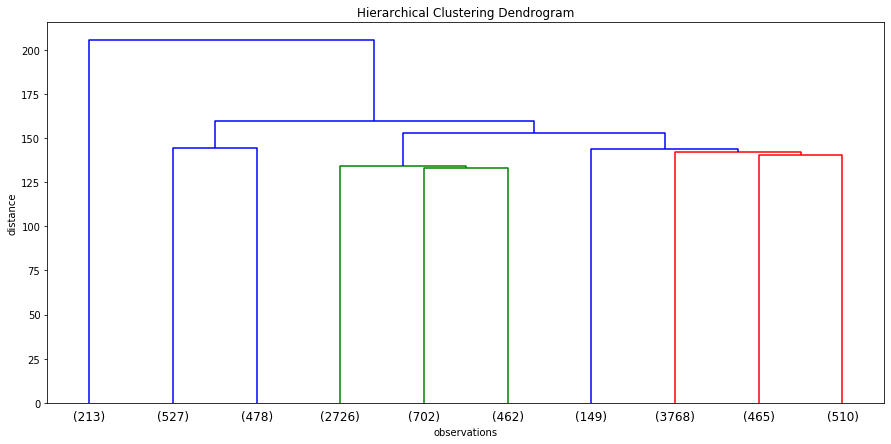

In [70]:
# number of clusters for truncating dendogram
p = 10

# plotting the dendogram
plot_dendrogram(Z, p=p)

### Sélection des hyper-paramètres

### Visualisation par réduction dimensionnelle

In [71]:
def plot_clusters(standardized_features, clusters_labels, embedding_algo='tSNE', ax=None):
    """
    Arguments:
    ---------
    embedding_algo: 'tSNE' or 'PCA' or 'Isomap'
    """
    
    # Applying the embedding
    #-----------------
    # Import libraries
    from sklearn import manifold
    from sklearn import decomposition
    
    # Instanciation of the embedding
    if embedding_algo == 'tSNE':
        # Instanciation of t-SNE
        embedding_instance = manifold.TSNE(
            n_components=2, # for projection in a plane
            perplexity=30,
            n_iter=300,
            init='pca', # initialisation by a PCA
            random_state=0
        )
    
    elif embedding_algo == 'Isomap':
        # Instanciation of Isomap
        embedding_instance = manifold.Isomap(
            n_components=2  # for projection in a plane
        )
        
    elif embedding_algo == 'PCA':
        # Instanciation of PCA
        embedding_instance = decomposition.PCA(
            n_components=2 # for projection in a plane
        )
    
    # Applying the embedding algorithm
    X_projected = embedding_instance.fit_transform(X_std)
    
    # Plotting the Isomap embedding
    #-----------------------------
    
    # If no axes is passed…
    if not ax:
        # Set the axes to the current one
        ax = plt.gca() # ax = ax or plt.gca() # 'a or b' instruction returns first True value   
        # Set dimensions of the figure (if no axes is passed)
        plt.gcf().set_figwidth(12)
        plt.gcf().set_figheight(7)
    
    # Definitions of axis boundaries
    ax.set_xlim(X_projected[:,0].min()*1.1, X_projected[:,0].max()*1.1)
    ax.set_ylim(X_projected[:,1].min()*1.1, X_projected[:,1].max()*1.1)

    # Properties of the axes
    ax.set_title(embedding_algo, fontsize=20)

    # Name of x- and y- axis, with percentage of explained variance
    ax.set_xlabel("First Isomap component")
    ax.set_ylabel("Second Isomap component")
    
    
    if embedding_algo == 'PCA': 
        # Names of x- and y- axis, with percentage of explained variance  
        ax.set_xlabel('First component ({}%)'.format(round(100*embedding_instance.explained_variance_ratio_[0],1)))
        ax.set_ylabel('Second component ({}%)'.format(round(100*embedding_instance.explained_variance_ratio_[1],1)))
    else:
        ax.set_xlabel('First component')
        ax.set_ylabel('Second component')
        
    # Setting color
    NB_CLUSTERS = len(set(clusters_labels)) - (1 if -1 in clusters_labels else 0)
    color = clusters_labels / NB_CLUSTERS
    
    # Setting color to black for noise points
    # color = pd.Series(clusters_labels / NB_CLUSTERS).astype('object')
    # color = color.map(lambda x: x if x != (-1 / NB_CLUSTERS) else 'black')
    
    # Plotting the scatter plot
    ax.scatter(
            X_projected[:,0], # x-coordinate
            X_projected[:,1], # y-coordinate
            c=color, # base for coloration of points
            cmap=plt.cm.get_cmap('Set1'), # colormap
            )

In [72]:
def clustering_plots(algorithm_name, standardized_features, clusters_labels):

    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec

    fig = plt.figure()

    # Set properties of the figure
    fig.set_figheight(6)
    fig.set_figwidth(23)
    fig.suptitle('Visualisation of clustering with {}'.format(algorithm_name), fontsize=20)

    # Set the geometry of the grid of subplots
    gs = gridspec.GridSpec(nrows=1, ncols=3,)

    # Initialize axes and set position (left to right, top to bottom)
    # Use sharex or sharey parameter for sharing axis
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    ax3 = fig.add_subplot(gs[2])

    # Filling the axes
    plot_clusters(standardized_features, clusters_labels, embedding_algo='tSNE', ax=ax1)
    plot_clusters(standardized_features, clusters_labels, embedding_algo='PCA', ax=ax2)
    plot_clusters(standardized_features, clusters_labels, embedding_algo='Isomap', ax=ax3)

    # Automatically adjusts subplots params to fit the figure
    gs.tight_layout(fig, rect=[0, 0, 1, 0.96])
    
    fig.savefig('plots/embedding.png');

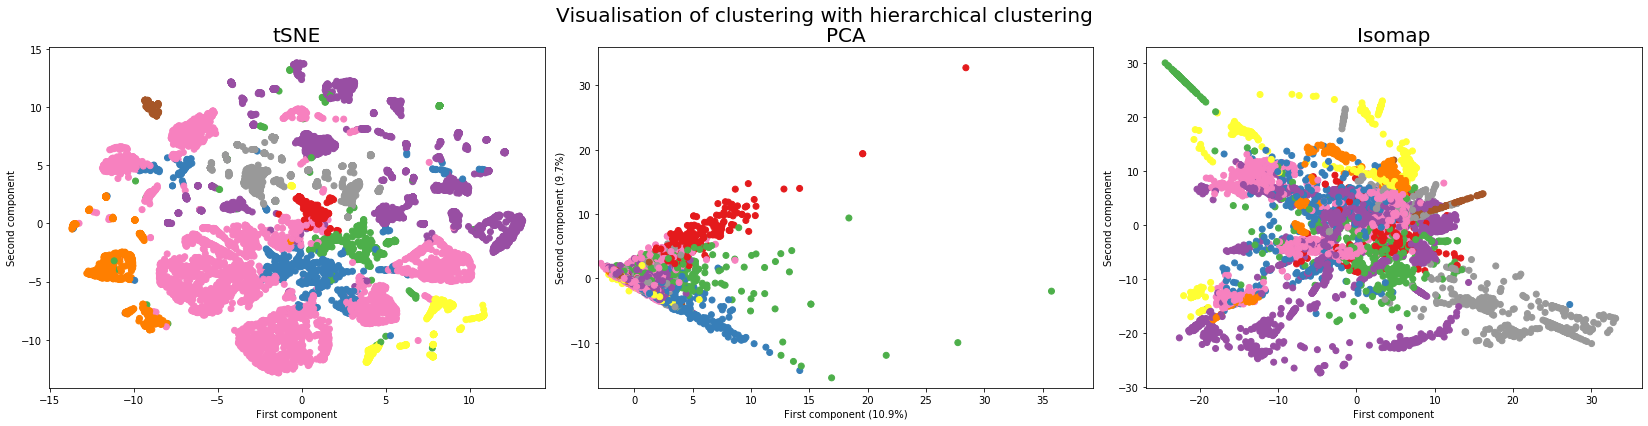

In [73]:
# Setup for call to the clustering_plots function
algorithm_name = 'hierarchical clustering'
standardized_features = X_std
clusters_labels = clusters

clustering_plots(algorithm_name, standardized_features, clusters_labels)

### Évaluation de la partition

In [74]:
algorithm_name = 'hierarchical clustering'
standardized_features = X_std
clusters_labels = clusters

# Computes and displays results
metrics_clustering(algorithm_name, standardized_features, clusters_labels, results_df)

Estimated number of clusters: 10

Silhouette coefficient: s = 0.139
  Notice: values closer to 1 indicate a better partition

Davies-Bouldin indice: D = 2.032
  Notice: values closer to 0 indicate a better partition

Gini coefficient: G = 0.449
  Notice: values closer to 0 indicate homogenic frequencies for clusters.



,Nb of clusters,Silhouette,Davies-Bouldin,Gini,Training time,Training time (s)
hierarchical clustering,10.0,0.138630,2.031757,0.4494,0.0254128,0.02625
Naïve model,2.0,0.000032,80.871124,0.0011,NaN,NaN


## ***k-MEANS***

### Définition de l'espace de recheche des hyper-paramètres

In [26]:
# Definition of the search space for hyperparameters
param_grid = {
    "n_clusters":  range(2, 10), # number of clusters
}

In [27]:
def cartesian_product(dictionary):
    """Generator object that a list of dicts of cartesian product combinations.
    use :
    -----
    for combination in cartesian_product(param_grid):
    """
    import itertools

    return (dict(zip(dictionary, x)) for x in itertools.product(*dictionary.values()))

### Application de l'algorithme et ajustement des hyper-paramètres

In [28]:
# Parameters
param_grid = param_grid
research = 'GridSearch'

# def hyperparameters_search_clustering():
from sklearn import cluster
from sklearn.metrics import silhouette_score

# Initialization
silouette_scores = []
best_score = 0

# Iterating on each combination of hyperparameters (GridSearch)
if research == 'GridSearch':
    combinations_to_test = cartesian_product(param_grid)
    
elif research == 'RandomGrid':
    # Not implemented yet
    pass
    
for params_combination in combinations_to_test:
    
    # Instanciation
    model = cluster.KMeans(
        init='k-means++',
        n_jobs=-1,
        n_init=10,
        random_state=seed,
        **params_combination,
    )

    # Fitting the clustering algorithm and measuring training time
    time_train_iteration = %timeit -n1 -r1 -o -q model.fit(X_std)

    # Scoring
    labels = model.labels_
    silhouette = silhouette_score(X_std, labels, metric='euclidean')
    silouette_scores.append(silhouette)

    # Getting best_model
    if silhouette > best_score:
        # Save best model
        best_model = model
        # Update best score
        best_score = silhouette
        # Update time_train
        time_train = time_train_iteration

In [29]:
    # Instanciation
    model = cluster.KMeans(
        init='k-means++',
        n_jobs=-1,
        n_init=10,
        random_state=42,
    )

### Influence des hyper-paramètres

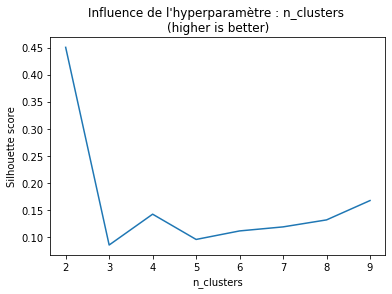

In [30]:
# Plotting the influence of the single hyperparameter
x = range(2, 10)
y = silouette_scores
plt.xlabel("n_clusters")
plt.ylabel("Silhouette score")
plt.title("Influence de l'hyperparamètre : n_clusters \n(higher is better)")
plt.plot(x, y);

### Réduction dimensionnelle et visualisation

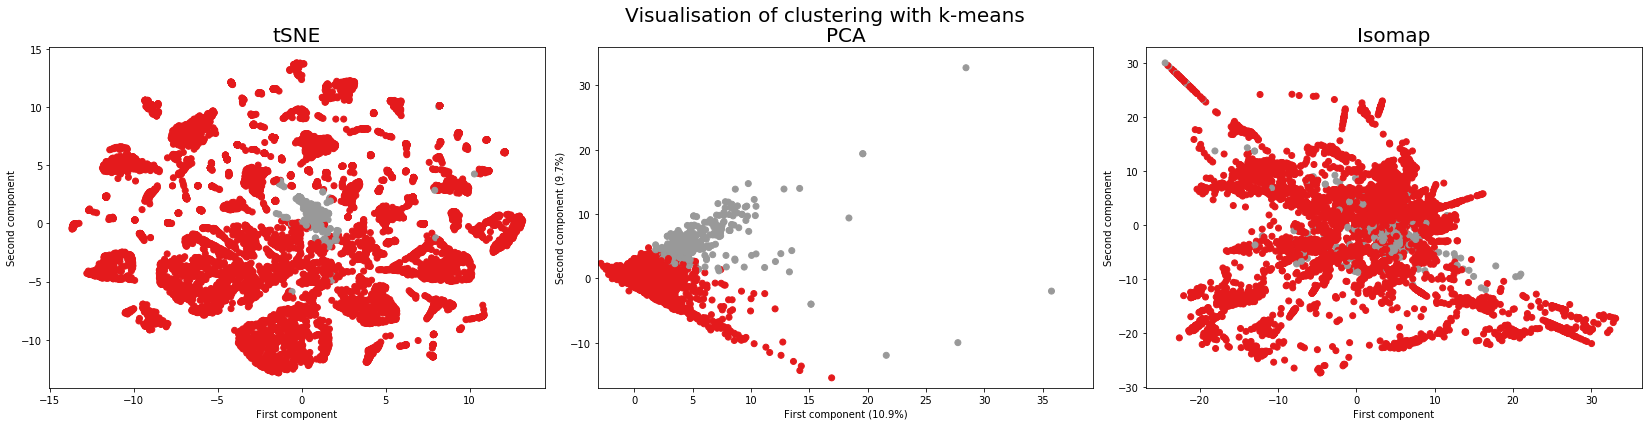

In [31]:
# Setup for call to the clustering_plots function
algorithm_name = 'k-means'
standardized_features = X_std
clusters_labels = best_model.labels_

clustering_plots(algorithm_name, standardized_features, clusters_labels)

### Évaluation de la partition

In [32]:
algorithm_name = 'k-means'
standardized_features = X_std
clusters_labels = best_model.labels_

# Adding the training time to the results DataFrame
results_df.loc[algorithm_name, 'Training time (s)'] = time_train.average

# Computes and displays results
metrics_clustering(algorithm_name, standardized_features, clusters_labels, results_df)

Estimated number of clusters: 2

Silhouette coefficient: s = 0.450
  Notice: values closer to 1 indicate a better partition

Davies-Bouldin indice: D = 1.491
  Notice: values closer to 0 indicate a better partition



,Nb of clusters,Silhouette,Davies-Bouldin
k-means,2.0,0.450482,1.491258
hierarchical clustering,10.0,0.138630,2.031757
Naïve model,2.0,-0.000049,118.217254


## **DBSCAN**
*Density-Based Spatial Clustering of Applications with Noise*

### Application de l'algorithme

In [33]:
# Definition of the search space for hyperparameters
param_grid = {
    'eps': [0.5],  # maximum distance that define neighborhood
    'min_samples': range(3,5), # number of neighbors to be considered as a core point
}

In [34]:
from sklearn.cluster import DBSCAN

# Instanciation of the clustering algorithm
db = DBSCAN(
    n_jobs=-1,
)

# Fitting the clustering algorithm
db.fit(X_std)

# Fitting the clustering algorithm and measuring training time
time_train = %timeit -n1 -r1 -o -q db.fit(X_std)

# Adding the training time to the results DataFrame
algorithm_name = 'DBSCAN'
results_df.loc[algorithm_name, 'Training time (s)'] = time_train.average

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=-1, p=None)

En jouant sur la valeur des hyper-paramètres eps et min_samples, nous pouvons modifier le nombre de classes trouvées par l'algorithme. Néanmoins, aucunes valeurs de ces hyper-paramètres ne permet de retrouver les 10 clusters du jeu de données initiales. Contrairement au k-means et au clustering hierarchique, DBSCAN ne permet pas de sélectionner le nombre de clusters.

### Réduction dimensionnelle (et visualisation)

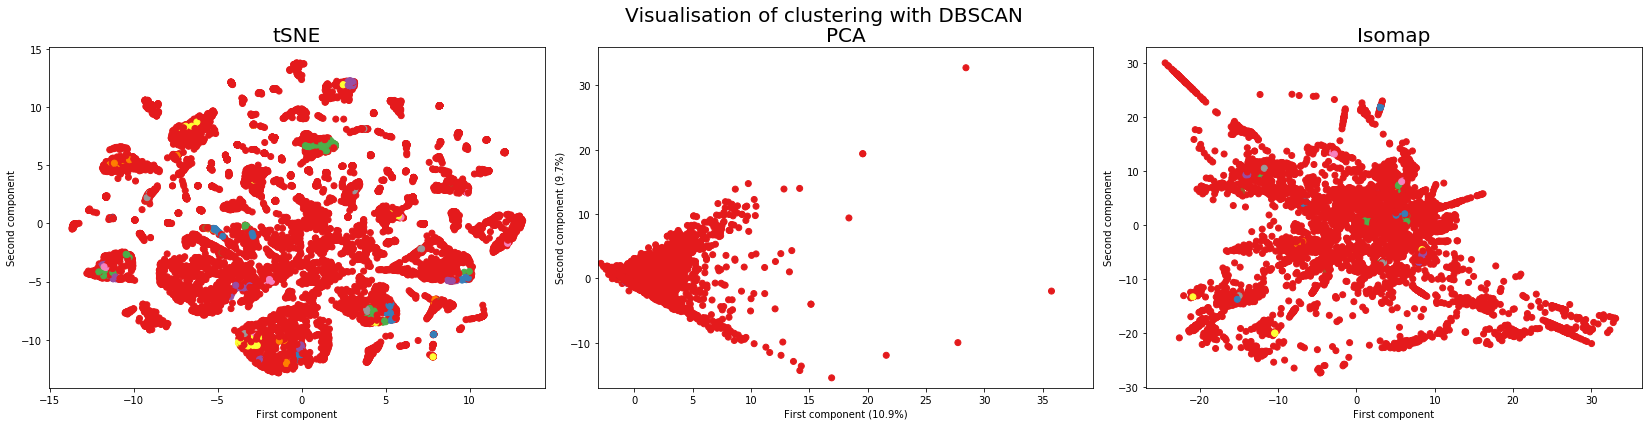

In [35]:
# Setup for call to the clustering_plots function
algorithm_name = 'DBSCAN'
standardized_features = X_std
clusters_labels = db.labels_

clustering_plots(algorithm_name, standardized_features, clusters_labels)

### Répartition des effectifs par segments

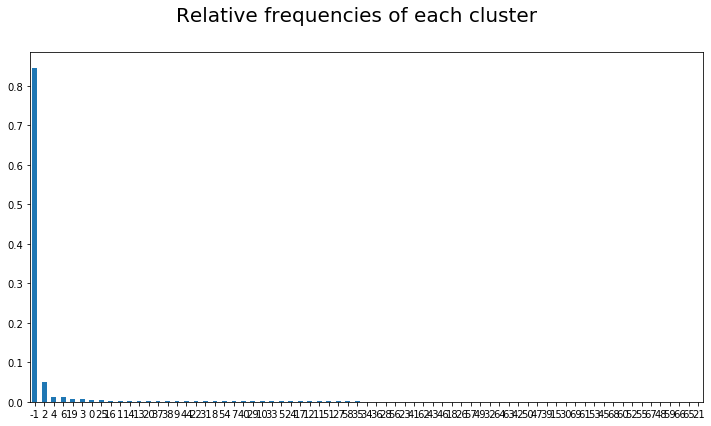

In [36]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure()

# Set properties of the figure
fig.set_figheight(6)
fig.set_figwidth(10)
fig.suptitle('Relative frequencies of each cluster', fontsize=20)

# Set the geometry of the grid of subplots
gs = gridspec.GridSpec(nrows=1, ncols=1,)

# Initialize axes and set position (left to right, top to bottom)
# Use sharex or sharey parameter for sharing axis
ax1 = fig.add_subplot(gs[0])

# Filling the axes
labels_counts = pd.Series(clusters_labels).value_counts() / len(clusters_labels)
labels_counts.plot.bar(ax=ax1)

# Rotation of ticks labels
plt.setp(ax1.get_xticklabels(), rotation='horizontal')

# Automatically adjusts subplots params to fit the figure
gs.tight_layout(fig, rect=[0, 0, 1, 0.9])

fig.savefig('plots/clusters_frequencies.png');

### Évaluation de la partition

In [37]:
algorithm_name = 'DBSCAN'
standardized_features = X_std
clusters_labels = db.labels_

# Computes and displays results
metrics_clustering(algorithm_name, standardized_features, clusters_labels, results_df)

Estimated number of clusters: 70

Silhouette coefficient: s = -0.428
  Notice: values closer to 1 indicate a better partition

Davies-Bouldin indice: D = 1.499
  Notice: values closer to 0 indicate a better partition



,Nb of clusters,Silhouette,Davies-Bouldin
k-means,2.0,0.450482,1.491258
hierarchical clustering,10.0,0.138630,2.031757
Naïve model,2.0,-0.000049,118.217254
DBSCAN,70.0,-0.428445,1.499348


# **Analyse** des résultats

### **Qualité** des partitions

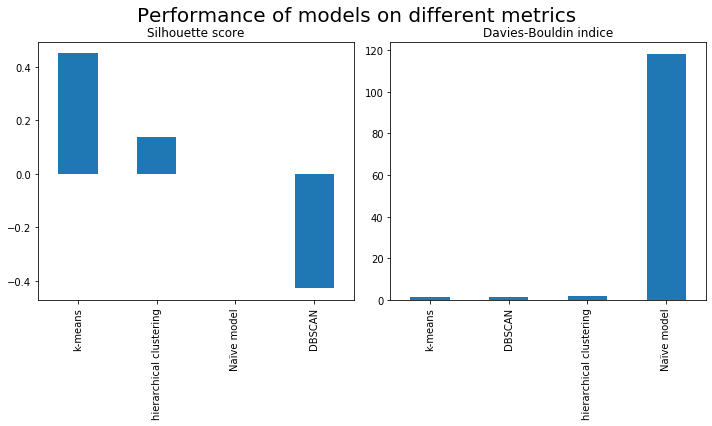

In [39]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure()

# Set properties of the figure
fig.set_figheight(6)
fig.set_figwidth(10)
fig.suptitle('Performance of models on different metrics\n', fontsize=20)

# Set the geometry of the grid of subplots
gs = gridspec.GridSpec(nrows=1, ncols=2,)

# Initialize axes and set position (left to right, top to bottom)
# Use sharex or sharey parameter for sharing axis
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

# Filling the axes
results_df['Silhouette'].sort_values(ascending=False).T.plot.bar(ax=ax1)
results_df['Davies-Bouldin'].sort_values(ascending=True).T.plot.bar(ax=ax2)

# Rotation of ticks labels
# plt.setp(ax1.get_xticklabels(), rotation='horizontal')
ax1.set_title("Silhouette score")
ax2.set_title("Davies-Bouldin indice")

# Automatically adjusts subplots params to fit the figure
gs.tight_layout(fig, rect=[0, 0, 1, 0.96])

fig.savefig('plots/metrics.png');

### **Nombre de clusters** optimal avec chaque algorithme

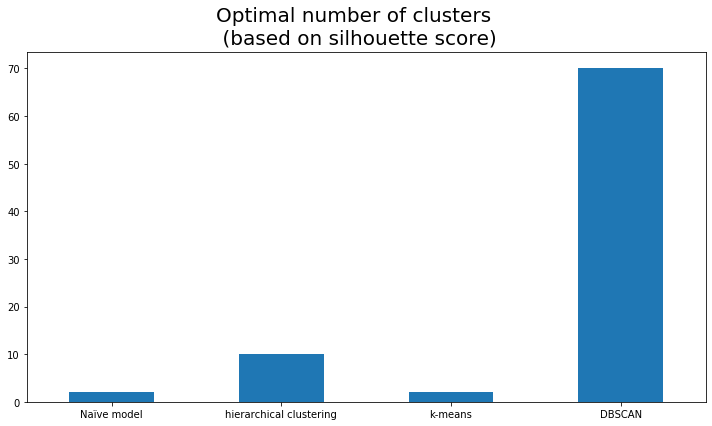

In [38]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure()

# Set properties of the figure
fig.set_figheight(6)
fig.set_figwidth(10)
fig.suptitle('Optimal number of clusters \n (based on silhouette score)', fontsize=20)

# Set the geometry of the grid of subplots
gs = gridspec.GridSpec(nrows=1, ncols=1,)

# Initialize axes and set position (left to right, top to bottom)
# Use sharex or sharey parameter for sharing axis
ax1 = fig.add_subplot(gs[0])

# Filling the axes
results_df['Nb of clusters'].T.plot.bar(ax=ax1)

# Rotation of ticks labels
plt.setp(ax1.get_xticklabels(), rotation='horizontal')

# Automatically adjusts subplots params to fit the figure
gs.tight_layout(fig, rect=[0, 0, 1, 0.9])

fig.savefig('plots/nb_clusters.png');

### **Homogénéité** des effectifs des groupes

### Coefficient de Gini de la partition
* coefficient de Gini : $ G = \frac{MAD}{2·\overline{n_k}} $
* effectif moyen des groupes : $\overline{n_k} = \frac{1}{K} \sum\limits_{k=1}^K |C_k| = \frac{n}{K}$
* différence absolue moyenne des effectifs : $ MAD = \frac{1}{K^2} \sum\limits_{k_1=1}^K \sum\limits_{k_2=1}^K ||C_{k_1}| - |C_{k_2}||$

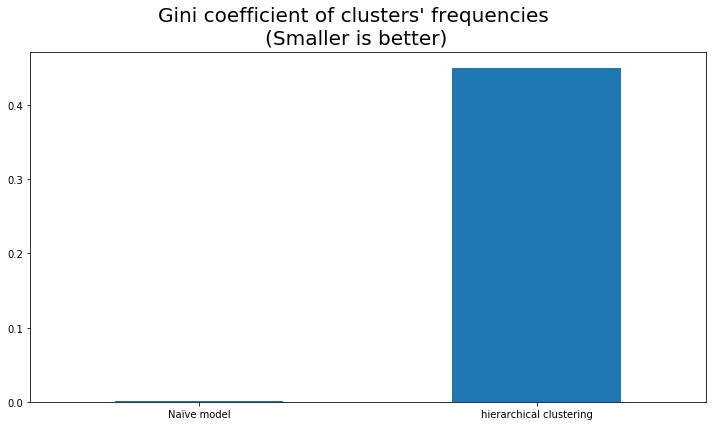

In [79]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure()

# Set properties of the figure
fig.set_figheight(6)
fig.set_figwidth(10)
fig.suptitle("Gini coefficient of clusters' frequencies \n(Smaller is better)", fontsize=20)

# Set the geometry of the grid of subplots
gs = gridspec.GridSpec(nrows=1, ncols=1,)

# Initialize axes and set position (left to right, top to bottom)
# Use sharex or sharey parameter for sharing axis
ax1 = fig.add_subplot(gs[0])

# Filling the axes
results_df['Gini'].T.plot.bar(ax=ax1)

# Rotation of ticks labels
plt.setp(ax1.get_xticklabels(), rotation='horizontal')

# Automatically adjusts subplots params to fit the figure
gs.tight_layout(fig, rect=[0, 0, 1, 0.9])

fig.savefig('plots/gini.png');

### **Temps** de calcul

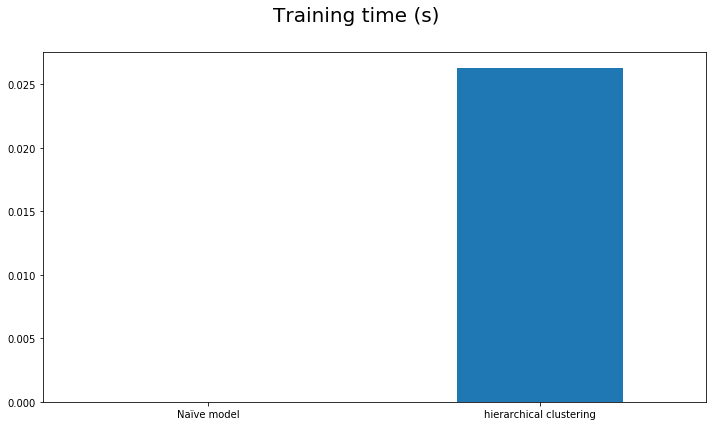

In [76]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure()

# Set properties of the figure
fig.set_figheight(6)
fig.set_figwidth(10)
fig.suptitle('Training time (s)', fontsize=20)

# Set the geometry of the grid of subplots
gs = gridspec.GridSpec(nrows=1, ncols=1,)

# Initialize axes and set position (left to right, top to bottom)
# Use sharex or sharey parameter for sharing axis
ax1 = fig.add_subplot(gs[0])

# Filling the axes
results_df['Training time (s)'].T.plot.bar(ax=ax1)

# Rotation of ticks labels
plt.setp(ax1.get_xticklabels(), rotation='horizontal')

# Automatically adjusts subplots params to fit the figure
gs.tight_layout(fig, rect=[0, 0, 1, 0.9])

fig.savefig('plots/training_time.png');

# **Profilage** des catégories de clients

In [90]:
standardized_features = X_std
# clusters_labels = db.labels_ # DBSCAN
clusters_labels = clusters # hierarchical clustering
# clusters_labels = best_model.labels_ # k-means

In [91]:
# Convert labels to pandas.DataFrame
clusters_labels = pd.Series(clusters_labels)

In [92]:
clusters_labels.unique()

array([ 4,  8,  3,  9,  2, 10,  5,  6,  1,  7], dtype=int64)

### **Ré-échelonnage** des valeurs (0 à 100)

In [41]:
from sklearn.preprocessing import MinMaxScaler

# Rescale the features from 0 to 100
scaler = MinMaxScaler(feature_range=(0, 100))
scaled_features = scaler.fit_transform(standardized_features)

# Convert back to a pd.DataFrame
features_names = standardized_features.columns
scaled_features = pd.DataFrame(scaled_features, columns=features_names)

### **Agrégation** des caractéristiques

In [93]:
# Convert labels to pandas.DataFrame
clusters_labels = pd.Series(clusters_labels)

# Get the list of clusters and name of features
list_clusters = list(clusters_labels.unique())
features_names = scaled_features.columns

# Initializing a pd.DataFrame to store aggregate values
clusters_agg_df = pd.DataFrame(columns = [feature_name for feature_name in features_names])

# Iterating upon clusters
for cluster_index in list_clusters:
    # Getting elements of the cluster
    mask = (clusters_labels == cluster_index)
    nb_points_in_cluster = len((clusters_labels[mask]))
    # print(cluster_index, nb_points_in_cluster)
    
    # Add to the DataFrame for results
    # clusters_agg_df.loc[cluster_index, 'frequency'] = nb_points_in_cluster
    
    # For each feature
    for feature in scaled_features.columns:
        # compute the mean
        mean_of_feature_for_cluster = scaled_features[mask][feature].mean()
        clusters_agg_df.loc[cluster_index, feature] = mean_of_feature_for_cluster

### **Diagrammes** de Kiviat 

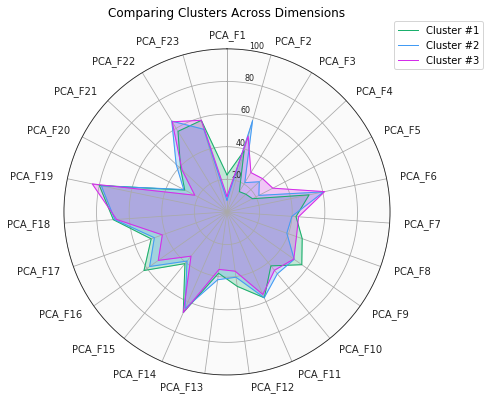

In [97]:
# Each feature to plot in the radar chart.
features_names = clusters_agg_df.columns
num_vars = len(features_names)

# Split the circle into even parts and save the angles
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is a circle, so we need to "complete the loop"
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Helper function to plot each cluster on the radar chart.
def add_to_radar(cluster_index, color):
    values = clusters_agg_df[features_names].loc[cluster_index].tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=1, label="Cluster #"+str(cluster_index))
    ax.fill(angles, values, color=color, alpha=0.25)

# Add clusters to the chart
add_to_radar(1, '#1aaf6c')
add_to_radar(2, '#429bf4')
add_to_radar(3, '#d42cea')

# Fix axis to go in the right order and start at 12 o'clock.
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Draw axis lines for each angle and label.
ax.set_thetagrids(np.degrees(angles), features_names)

# Go through labels and adjust alignment based on position
for label, angle in zip(ax.get_xticklabels(), angles):
    if angle in (0, np.pi):
        label.set_horizontalalignment('center')
    elif 0 < angle < np.pi:
        label.set_horizontalalignment('left')
    else:
        label.set_horizontalalignment('right')

# Ensure radar goes from 0 to 100.
ax.set_rgrids([20, 40, 60, 80, 100])

# Set position of y-labels (0-100)
ax.set_rlabel_position(180 / num_vars)

# Add some custom styling.
# Change the color of the tick labels.
ax.tick_params(colors='#222222')
# Make the y-axis (0-100) labels smaller.
ax.tick_params(axis='y', labelsize=8)
# Change the color of the circular gridlines.
ax.grid(color='#AAAAAA')
# Change the color of the outermost gridline (the spine).
ax.spines['polar'].set_color('#222222')
# Change the background color inside the circle itself.
ax.set_facecolor('#FAFAFA')

# Add title
ax.set_title('Comparing Clusters Across Dimensions', y=1.08)

# Add a legend
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1));

fig.savefig('plots/kiviat.png');

# **Stabilité temporelle** de la segmentation
Protocole:
1. fitter l'algorithme de clustering sur une première fraction du jeu de données.
2. utiliser la méthode predict sur un échantillonnage de test (environ 1'000 points), en modifiant peut-être les datestamps pour donner l'illusion qu'ils sont récents. Ces étiquettes prédites me donnent la partition de référence (considérées comme les vraies étiquettes pour la mesure de l'ARI).
3. refitter l'algorithme sur une autre fraction du jeu de données.
4. Utiliser à nouveau la methode predict sur l'échantillon de test.
5. Calculer l'ARI entre la partition initiale ('vraies labels') et la partition obtenue à partir de la seconde fraction.

### **Fractionnement** temporel des données

In [ ]:
from datetime import datetime, timedelta

for month_index in range(1, 24):
    time_window = timedelta(days=30*month_index)
    mask = data['recency'] > (data['recency'].max() - time_window)
    cumulated_data = data[mask]
    # print(len(data[mask]))

### Application du modèle de segmentation

In [ ]:
from sklearn.metrics.cluster import adjusted_rand_score

ARI_scores = []

# Applying preprocessing (standardization)
(X_std, _) = preprocessing(cumulated_data)

# Instanciation
model = cluster.KMeans(
        init='k-means++',
        n_jobs=-1,
        n_init=10,
        random_state=seed,
        n_clusters=5,
    )
    
# Fitting
model.fit(X_std)

if month_index == 1:
    # Predicting the initial clusters labels for the test sample
    reference_clustering = model.predict(X_test_std)

# Predicting the clusters labels for the test sample
test_clustering = model.predict(X_test_std)

# Computing and saving ARI score between the two clustering
# Values closer to 1 indicate a better partition.
ARI_scores += adjusted_rand_score(
    reference_clustering,
    test_clustering,
)

### **Visualisation** de l'évolution du modèle de partitionnement

In [ ]:
# Graphing evolution of ARI score



# Algorithmes de segmentation

* **Algorithmes**
    * k-means (k-means++, avec et sans noyau)
    * Expectation–Maximization (EM)
    * Clustering using Gaussian Mixture Models (GMM)
    * Mean-Shift Clustering
    * OPTICS (https://scikit-learn.org/stable/modules/clustering.html)
    * [...]

# TO-DO LIST

* Optimisation des hyper-paramètres
    * Recherche des hyper-paramètres pour les algorithmes de clustering
    * Représentation de l'influence des hyper-paramètres
    * Implémenter une recherche aléatoire sur grille (sans validation croisée)
    * Retrouver TP du cours évaluer un modèle (implémentation de validation croisée ?)


* Description "actionnable" : 
    * après segmentation, description des segments (clusters). Ex : type de produit, quantité de produit…
    * Diagrammes RADAR pour les clusters avec les variables + écart-type


* Stabilité
    * Stabilité : injection de bruit ou modification de paramètres avant de relancer (non implémenté sous sklearn)
    * Stabilité des clusters : faire une fonction pour identifier les clusters de deux partitions différentes, en se basant sur une matrice de confusion
    * Stabilité des clusters : faire une animation sous matplotlib
    * Stabilité des clusters à l'initialisation : se baser sur l'ARI moyenne entre différentes itérations.
    * Tester la stabilité des clusters :
        * à l'initialisation (aléatoire)
        * dans le temps (segmentation de l'intervalle de temps considéré)
    * Stabilité dans le temps : voir avec l'indicateur ARI si possible…

    
* Autres
    * Créer une fonction customisée pour calculer la distance entre deux points. Les méthodes de clustering se basent sur la notion de distance… Attention : distance euclidienne ok pour les variables numériques, mais pas adapté pour les variables catégorielles et booléennes
    * Faire un push sur GitHub
    * Éliminer les features non-pertinentes pour le clustering (peu de variance, ou non significative). Se baser sur les tests d'indépendance ou ANOVA à un facteur.
    * Mettre en place une méthode de "Consensus Clustering"
    * minibatch k-means pour augmenter la vitesse
    * Variance inter- et intra- cluster ???
    * Rééchelonner entre 0% et 100% : coefficient de Gini, training time…

# **QUESTIONS & TO FIX LIST**
* Installation de Spark Apache


* Jointure à gauche + imputation ou suppression OU jointure intérieure ?
* Ajout extension au notebook pour développer-réduire les sections
* Solution pour tester la conformité PEP8 sur l'ensemble du NoteBook ?
* Gestion des valeurs hors-normes : après la segmentation ? (classé en bruit : -1) Elliptic ?
* Gestion des timeseries par les algorithmes : conversion en float ?

# Consignes

L’intention de ce projet est de réaliser une segmentation de clients, au travers de la préparation et mise en œuvre de transformations de features numériques et catégorielles (features engineering), de la mise en œuvre des modèles d’apprentissage non supervisés, de la sélection d’un modèle et l’optimisation de ses hyperparamètres.

Le nombre de segments de clients doit permettre de bien différencier les clients, afin que l’équipe Marketing puisse mettre en place des actions ciblées, mais doit rester raisonnable afin de maîtriser leur charge de travail proportionnelle à ce nombre.

L’étudiant pourra s’inspirer de démarches de segmentation connues en fonction des données à disposition, afin de créer les features adaptées. :
 * segmentation tactique RFM (Recency,  Frequency,  Monetary) :
     * Récence (date de la dernière commande)
     * Fréquence des commandes
     * Montant (de la dernière commande ou sur une période donnée)
 * segmentation Personae (profils) :
     * représentation fictive d’un client typique à l’intérieur d’un profil donné
 * segmentation "à la performance" :
     * détecter les personnes les plus susceptibles de réaliser un achat
     * scoring, et segmentation sur le score (hot, warm, cold prospects)
 * segmentation comportementales :
     * basées sur les comportements des clients ou prospect
     * modes d’achat (lieu, conditionnement…)
     * volumes d’achat
     * modes de consommation
     * canaux utilisés (notamment services d’assurance ou bancaires)
     * comportements de visites d’un site web ou d’usage d’une application
     * réactions à la réception des emails
 * segmentation "a priori" :
     * choisir a priori le ou les critères utilisés pour faire la segmentation

Incitez l’étudiant à mettre en œuvre des fonctions de comparaison des résultats des modèles selon différents indicateurs (score, temps de calcul, …), permettant de choisir celui adapté à la problématique et aux moyens techniques à disposition.